# The Balanced Counts Problem

In this tutorial we will address the task of predicting the quality of a wine based on some features. In addition to the straight-forward classification task, we pose an external requirement: each output class must have (approximately) the same probability of being predicted, i.e., our predictive model must be balanced towards all the classes.

Rather than on the ideas behind the Moving Targets (MT) algorithm, this and the following tutorials will focus on how to use the Moving Targets APIs. We will indeed show some basic objects of the library, as well as some ways to customize the process in order to have the desired degree of control in all of your experiments.

> NOTE: since we will leverage on the [Gurobi](https://www.gurobi.com/) solver to deal with the master problem, you will need to install it separately. A free academic license for the solver can be obtained [here](https://www.gurobi.com/academia/academic-program-and-licenses/). Otherwise, you may change the line of code involving the backend object and use one among the other supported backends.

In [1]:
import numpy as np
import seaborn as sns

np.random.seed(0)
sns.set_style('whitegrid')
sns.set_context('notebook')

## A Look at the Data

As a first step, we retrieve the dataset and inspect it.

The dataset is cleansed, indeed no missing values are present. It contains $11$ input features, which are neither normalized nor standardized apart from the *citric acid* column, while the target vector (*quality*) consists of integer values ranging from $3$ to $8$.

In [2]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/moving-targets/moving-targets/main/res/redwine.csv')
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


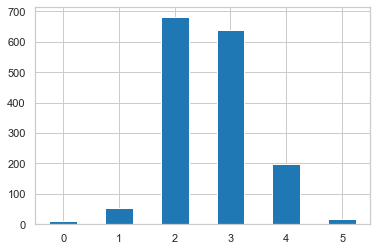

In [3]:
x, y = df.drop(columns='quality'), df['quality'].astype('category').cat.codes
y.value_counts().sort_index().plot(kind='bar', rot=0);

Simply by looking at the classes' distribution, it is clear that the input data does not satisfy the balancing constraint.

We can quantify this violation by computing the standard deviation of the class counts, since balanced output classes will lead to zero standard deviation.

In [4]:
print(f'Constraint violation: {np.std(y.value_counts())}')

Constraint violation: 285.0454642099514


## The Unconstrained Problem

Before diving into the whole Moving Targets process, let us split the data points into a train and test set and measure the performances of a baseline model trained to solve the unconstrained problem.

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, shuffle=True)

In order to keep the algorithm as simple as possible, we will use a standard *Logistic Regression* model. Still, instead of relying on the usual `scikit-learn` implementation, we will show how to use the `moving-targets` wrappers.

Since they conform to the traditional class interface containing the `fit` and `predict` methods, MT learners may serve both as standalone machine learning models and (obviously) within the Moving Targets pipeline. Optionally, these learners might provide for additional features that increase the level of abstraction.

For example, MT `LogisticRegression` is structured like this:
```python
LogisticRegression(task='auto', polynomial=None, x_scaler=None, y_scaler=None, stats=False, **model_kwargs)
```
where:
* ***task*** - indicates the kind of classification task. It can be either **binary**, **multiclass**, or **auto** for automatic task detection;
* ***polynomial*** - indicates the degree used to generate polynomial features during the preprocessing phase, or *None* for no preprocessing;
* ***x_scaler*** - either a string representing the default scaling method for the input data used in the preprocessing phase, or *None* for no preprocessing;
* ***y_scaler*** - either a string representing the default scaling method for the output data used in the preprocessing phase, or *None* for no preprocessing;
* ***stats*** - indicates whether to log the learner statistics (this is useful only within the MT pipeline);
* ***model_kwargs*** - additional arguments passed to the `sklearn.linear_model.LogisticRegression` object, which is wrapped by this learner.

In [6]:
from moving_targets.learners import LogisticRegression

learner = LogisticRegression(x_scaler='std', max_iter=10000)
learner.model

LogisticRegression(max_iter=10000)

As we can see, our learner wraps the `scikit-learn` ones, but complies with the Moving Targets' `Learner` interface.

The way to fit it and obtain predictions from it is exactly the same as any `scikit-learn` model. Once we do that, we can measure the performances of our machine learning model according to the loss function (*binary crossentropy*), a task-specific metric (*accuracy score*), and the constraint violation (*classes standard deviation*).

In [7]:
from sklearn.metrics import log_loss, accuracy_score

def classes_std(p):
    return np.unique(p, return_counts=True)[1].std()

learner.fit(x_train, y_train)
prob_test = learner.predict(x_test)
pred_test = prob_test.argmax(axis=1)
prob_train = learner.predict(x_train)
pred_train = prob_train.argmax(axis=1) 

print('     |  train  |  test   ')
print('-----+---------+---------')
print(f' bce | {log_loss(y_train, prob_train):.5f} | {log_loss(y_test, prob_test):.5f}')
print(f' acc | {accuracy_score(y_train, pred_train):.5f} | {accuracy_score(y_test, pred_test):.5f}')
print(f' std | {classes_std(pred_train):.3f} | {classes_std(pred_test):.3f}')

     |  train  |  test   
-----+---------+---------
 bce | 0.91980 | 0.92423
 acc | 0.60384 | 0.60250
 std | 258.739 | 83.407


## Moving Targets

A rule of thumb in the data science field claims that the first question to pose when adopting a more complex method is: why should it be worth?

Let us recall the conclusions of the previous tutorial:
> Using MT instead of other methods for injecting constraints in ML model may be interesting when:
> 1. your constraints are not natively differentiable (e.g. they are defined on discrete variables);
> 2. your constraints are defined on a large number of examples (e.g. fairness indicators);
> 3. dealing with the constraint via alternative methods (e.g. regularization/Lagrangian approaches) slows down training a lot.

This scenario perfectly fits within the first and the second use cases. The balancing constraint is indeed non-differentiable since it is defined on the class targets rather than on the class probabilities (and the *argmax* operation cannot be differentiated), and it also regards the whole population and not just each sample on its own.

For this reason, we think that Moving Targets is in fact a viable option to address this task.

Remember that the Moving Targets' library is built upon three main building blocks:

* the `Learner` object which encapsulates the MT learner step
* the `Master` object which encapsulates the MT master step
* the `MACS` object which encapsulates the whole MT algorithm

Since we already saw how to use a `Learner`, and a `MACS` object is nothing more than a wrapper of the other two with some additional utility methods, the remaining step is to build a custom `Master` objects.

First, we need to subclass the `ClassificationMaster` class, which can be found in the `moving_targets.masters` package. This class contains the core of a master problem for **binary**, **multiclass**, and **multilabel** classification tasks, therefore the only methods to override is the `build` method, which contains the problem formulation, as well as the `__init__` method if needed.

In [8]:
from moving_targets.masters import ClassificationMaster 

class BalancedCounts(ClassificationMaster):
    def __init__(self, backend='gurobi', loss='hd', alpha='harmonic', stats=False):
        super().__init__(backend=backend, loss=loss, alpha=alpha, stats=stats, types='discrete', labelling=False)

    def build(self, x, y, p):
        # 1. RETRIEVE THE VARIABLES
        z = super(BalancedCounts, self).build(x, y, p)

        # 2. ADD THE CONSTRAINTS
        num_samples, num_classes = (len(y), 2) if y.ndim == 1 else y.shape
        max_count = np.ceil(num_samples / num_classes)
        self.backend.add_constraints([c <= max_count for c in self.backend.sum(z, axis=0)])

        # 3. RETURN THE VARIABLES
        return z

As you can see, the code is really short because all the algorithm details are automatically handled by the library. However, for a deeper understanding of the Moving Targets API's, let us explain what this lines of code do.

Within the `__init__` function we can see a number of (hyper-)parameters:
* ***backend*** - represents the backend instance which is used to solve the master problem. Currently, the library supports *cvxpy*, *cplex*, and *gurobi* as backends, and these can be passed either by name via a string, or by building a custom `Backend` object to manually set the backend parameters;
* ***loss*** - represents the loss function used to compute the master problem objective. Since we are dealing with class targets rather than class probabilities, in this case we will use the *hamming distance*. Similarly to the backend, we can either pass a string alias for the loss, or a custom `Loss` object;
* ***alpha*** - represents the alpha value (if constant) or the alpha optimizer. Again, we can either pass a string alias or an `Optimizer` object, or even a floating point value for a constant alpha. We will use the *harmonic* optimizer, which is the one providing theoretical guarantees for the convergence;
* ***stats*** - indicates whether to include master statistics in the history object returned by the training process (or, in case of a list of strings, which of the statistics to include specifically);
* ***types*** - indicates the solver variables types, either *discrete* or *continuous*. Since we are imposing the constraint on the class targets rather than the class probabilities, we need to use discrete variables;
* ***labelling*** - indicates whether this is a (multi-)labelling or a (multi-)class classification tasks, in case a bi-dimensional target vector is passed.

The `build` method, instead, implements these three actions:
1. retrieves the solver variables, which have the indicated types, the same shape of the target vector, and the correct bounds. Since we are in a multi-class classification scenario, the $z$ variables are already constrained so that elements in each row sum up to one;
2. uses the number of samples and classes to compute the upper bound for the number of counts of a class, then adds a constraint for each of the classes (i.e., constraints the sum of the variables on each column to be lower than the upper bound);
3. returns the variables.



We can now build the `MACS` object using the learner and master instances, along with the preferred ***initial step*** (*pretraining* to start with the learner step, *projection* to start with the master step) and an optional list of ***metrics***:

In [9]:
from moving_targets import MACS
from moving_targets.metrics import CrossEntropy, Accuracy, ClassFrequenciesStd

master=BalancedCounts()
learner=LogisticRegression(x_scaler='std', max_iter=10000)
metrics=[Accuracy(), CrossEntropy(), ClassFrequenciesStd()]
model = MACS(init_step='pretraining', master=master, learner=learner, metrics=metrics)

Finally, we proceed by fitting the `MACS` model with the training data.

Along with that, we pass the number of ***iterations***, a dictionary of ***validation data*** which indexes each tuple $(x_{split}, y_{split})$ by the split name, and a custom callback used to see the evolution of the class balancing during the iterations.

> Please notice that, even though the input data may be in each acceptable format (e.g., lists, numpy, pandas), the library always expects and returns a numpy array for the output data. 

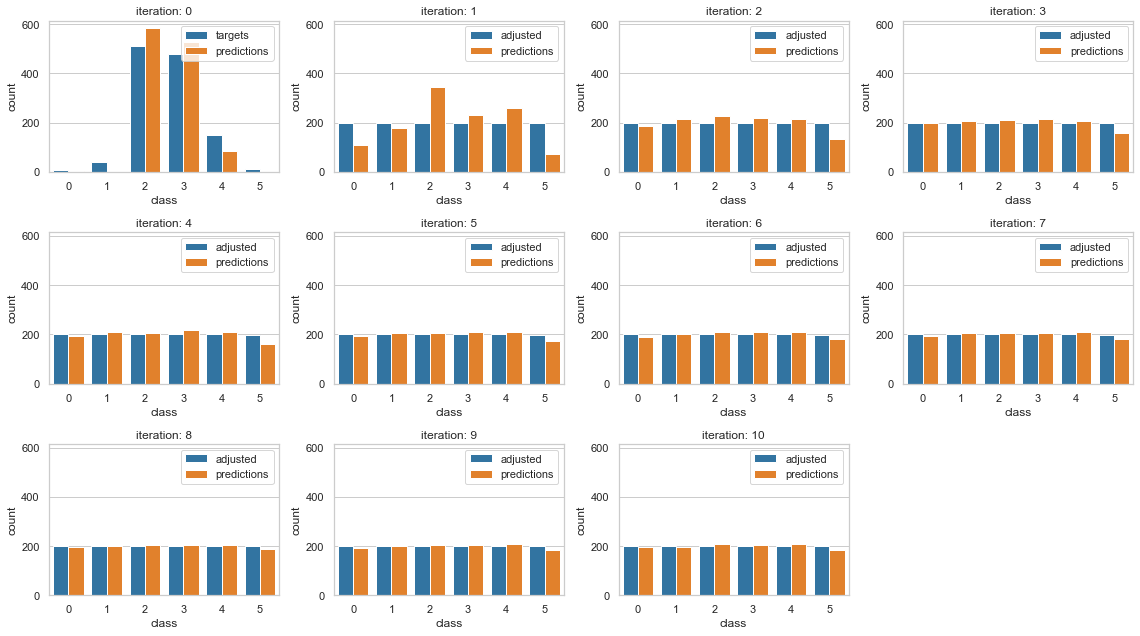

In [10]:
from util.balancing import ClassesHistogram

callbacks = [ClassesHistogram(figsize=(16, 9), tight_layout=True)]
val_data = dict(test=(x_test, y_test.values))
history = model.fit(x=x_train, y=y_train.values, iterations=10, val_data=val_data, callbacks=callbacks, verbose=False)

Finally, since we retrieved the `History` object returned by the `fit` method, which contains the statistics and the metrics collected during the training, we can now plot them:

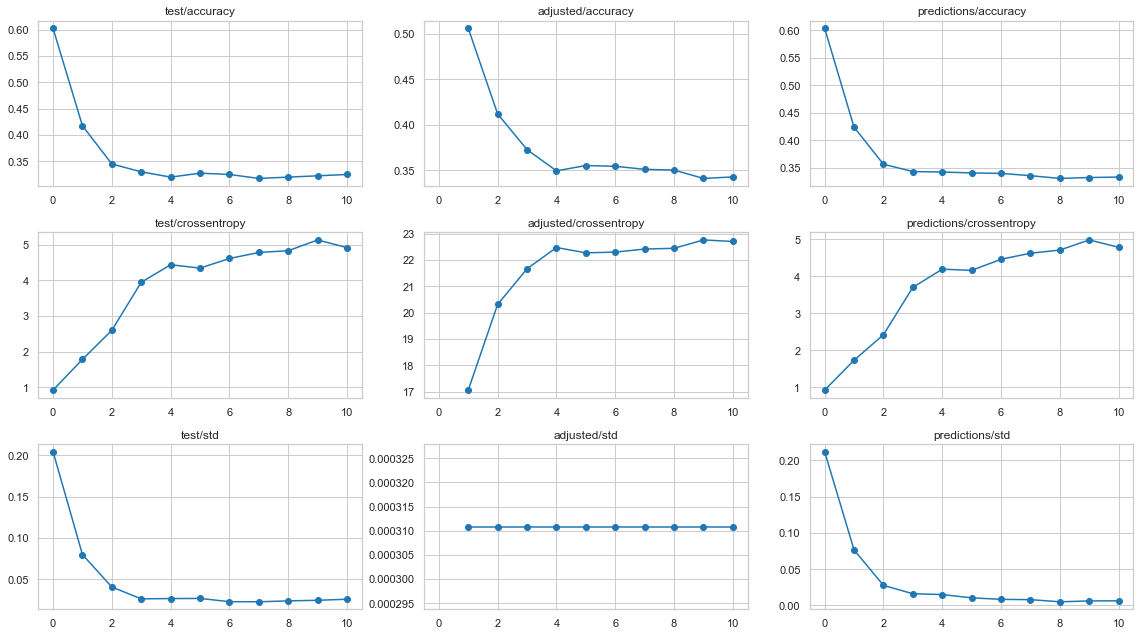

In [11]:
history.plot()

## Conclusions

In conclusion, we can see from the plots that we correctly managed to balance the output classes.

This has certainly come at the expenses of predictive accuracy, but it was nonetheless expected as the external requirements clashes with the target data distribution. Still, Moving Targets could effectively solve the constrained classification task by reaching the higher possible performances while sticking to the required constraints.

In the next tutorials we will see how to apply the same techniques for two real-world scenarios involving fairness requirements in regression and classification tasks.